In [5]:
!tar -xvzf /content/cifar-10-python.tar.gz


cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import torchsummary

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Constants
NUM_CLASSES = 10
BATCH_SIZE = 128
NUM_EPOCHS = 30
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-4
IMG_SIZE = 32
PATCH_SIZE = 4
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2
EMBED_DIM = 192
NUM_HEADS = 4
NUM_LAYERS = 6
MLP_RATIO = 4
DROPOUT = 0.1
VALIDATION_SPLIT = 0.1
CIFAR_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create directory for results
os.makedirs('results', exist_ok=True)

In [6]:
#--------------------------------------------------------------------------
# 1. Data Preprocessing and Augmentation
#--------------------------------------------------------------------------

def unpickle(file):
    """
    Unpickle the CIFAR-10 batch file
    """
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def get_data_loaders():
    """
    Prepare CIFAR-10 dataset with data augmentation and normalization from batch files
    Returns train, validation, and test data loaders
    """
    # Path to the CIFAR-10 batch files
    data_dir = '/content/cifar-10-batches-py'

    # Mean and standard deviation of CIFAR-10 dataset
    cifar10_mean = (0.4914, 0.4822, 0.4465)
    cifar10_std = (0.2470, 0.2435, 0.2616)

    # Load class names from batches.meta
    meta_file = os.path.join(data_dir, 'batches.meta')
    meta_data = unpickle(meta_file)
    class_names = [label.decode('utf-8') for label in meta_data[b'label_names']]
    print(f"Classes: {class_names}")

    # Load all training batches (data_batch_1 to data_batch_5)
    train_images = []
    train_labels = []

    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f'data_batch_{i}')
        batch_data = unpickle(batch_file)

        # Extract images and labels
        batch_images = batch_data[b'data']
        batch_labels = batch_data[b'labels']

        # Reshape images to (N, 3, 32, 32) format
        batch_images = batch_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

        train_images.append(batch_images)
        train_labels.extend(batch_labels)

    # Concatenate all training images
    train_images = np.vstack(train_images)
    train_labels = np.array(train_labels)

    # Load test batch
    test_file = os.path.join(data_dir, 'test_batch')
    test_data = unpickle(test_file)

    # Extract test images and labels
    test_images = test_data[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    test_labels = np.array(test_data[b'labels'])

    print(f"Training data shape: {train_images.shape}, Labels shape: {train_labels.shape}")
    print(f"Test data shape: {test_images.shape}, Labels shape: {test_labels.shape}")

    # Create custom datasets
    class CIFAR10_Custom(torch.utils.data.Dataset):
        def __init__(self, images, labels, transform=None):
            self.images = images
            self.labels = labels
            self.transform = transform

        def __len__(self):
            return len(self.labels)

        def __getitem__(self, idx):
            image = self.images[idx]
            label = self.labels[idx]

            # Convert to PIL Image for transforms
            image = Image.fromarray(image)

            if self.transform:
                image = self.transform(image)

            return image, label

    # Data augmentation for training
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(cifar10_mean, cifar10_std)
    ])

    # Just normalization for validation and test data
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cifar10_mean, cifar10_std)
    ])

    # Create full dataset
    full_train_dataset = CIFAR10_Custom(train_images, train_labels, transform=train_transform)
    test_dataset = CIFAR10_Custom(test_images, test_labels, transform=test_transform)

    # Split training dataset into train and validation
    dataset_size = len(full_train_dataset)
    indices = list(range(dataset_size))
    np.random.shuffle(indices)
    split_idx = int(np.floor(VALIDATION_SPLIT * dataset_size))
    train_indices, val_indices = indices[split_idx:], indices[:split_idx]

    # Create data samplers
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    # Create validation dataset with test transform
    val_dataset = CIFAR10_Custom(train_images, train_labels, transform=test_transform)

    # Create data loaders
    train_loader = DataLoader(
        full_train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler,
        num_workers=4, pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler,
        num_workers=4, pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=4, pin_memory=True
    )

    return train_loader, val_loader, test_loader

In [7]:
def visualize_samples(dataloader, num_samples=8):
    """Visualize sample images from the dataset"""
    examples = iter(dataloader)
    example_data, example_targets = next(examples)

    fig = plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        plt.subplot(2, 4, i+1)
        plt.imshow(example_data[i].permute(1, 2, 0).cpu().numpy())
        plt.title(f"Label: {CIFAR_CLASSES[example_targets[i]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('results/sample_images.png')
    plt.close()

    return example_data

In [8]:
#--------------------------------------------------------------------------
# 2. Vision Transformer (ViT) Implementation
#--------------------------------------------------------------------------

class PatchEmbedding(nn.Module):
    """
    Split an image into patches and embed them
    """
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=192):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        # Linear projection of flattened patches
        self.proj = nn.Conv2d(
            in_channels, embed_dim,
            kernel_size=patch_size, stride=patch_size
        )

    def forward(self, x):
        # x: (B, C, H, W)
        B, C, H, W = x.shape
        assert H == W == self.img_size, f"Input image size ({H}*{W}) doesn't match model ({self.img_size}*{self.img_size})"

        # (B, C, H, W) -> (B, E, H/P, W/P) -> (B, E, N) -> (B, N, E)
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x  # (B, N, E)

class Attention(nn.Module):
    """
    Multi-head Self-Attention mechanism
    """
    def __init__(self, dim, num_heads=4, qkv_bias=True, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        # qkv are calculated with a single linear layer for efficiency
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        # Calculate query, key, values for all heads in batch
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Calculate dot product attention
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # Apply attention to values
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class MLP(nn.Module):
    """
    Multi-Layer Perceptron for Transformer Block
    """
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features

        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Block(nn.Module):
    """
    Transformer Block: Communication + MLP
    """
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop
        )
        self.norm2 = nn.LayerNorm(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, drop=drop)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    """
    Vision Transformer (ViT) for image classification
    """
    def __init__(
        self, img_size=32, patch_size=4, in_channels=3, num_classes=10,
        embed_dim=192, depth=6, num_heads=4, mlp_ratio=4.,
        qkv_bias=True, drop_rate=0.1, attn_drop_rate=0.
    ):
        super().__init__()
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.num_tokens = 1  # Class token

        # Patch embedding
        self.patch_embed = PatchEmbedding(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=embed_dim
        )
        num_patches = self.patch_embed.n_patches

        # Class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

        # Position embeddings
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + self.num_tokens, embed_dim))

        # Dropout
        self.pos_drop = nn.Dropout(p=drop_rate)

        # Transformer blocks
        self.blocks = nn.Sequential(*[
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, drop=drop_rate, attn_drop=attn_drop_rate
            )
            for _ in range(depth)
        ])

        # Layer normalization
        self.norm = nn.LayerNorm(embed_dim)

        # Classifier head
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        # Initialize positional embedding
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)  # (B, N, E)

        # Add class token
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, E)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, N+1, E)

        # Add position embeddings
        x = x + self.pos_embed
        x = self.pos_drop(x)

        # Apply transformer blocks
        x = self.blocks(x)
        x = self.norm(x)

        # Use only the class token for classification
        return x[:, 0]

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

In [9]:
#--------------------------------------------------------------------------
# 3. Hybrid CNN-MLP Implementation
#--------------------------------------------------------------------------

class HybridModel(nn.Module):
    """
    Hybrid architecture: CNN feature extractor + MLP classifier
    Uses convolutional layers to extract features from image patches,
    then an MLP classifier for final prediction
    """
    def __init__(self, num_classes=10):
        super(HybridModel, self).__init__()

        # CNN Feature Extractor
        self.feature_extractor = nn.Sequential(
            # First conv block
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Second conv block
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Third conv block
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Calculate output feature dimensions (after 3 maxpool layers)
        feature_dim = 256 * (IMG_SIZE // 8) * (IMG_SIZE // 8)

        # MLP Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Extract features using CNN
        features = self.feature_extractor(x)
        # Classify using MLP
        output = self.classifier(features)
        return output

In [10]:
#--------------------------------------------------------------------------
# 4. ResNet Transfer Learning Implementation
#--------------------------------------------------------------------------

class ResNetTransfer(nn.Module):
    """
    Transfer learning model using pre-trained ResNet
    """
    def __init__(self, num_classes=10):
        super(ResNetTransfer, self).__init__()

        # Load pre-trained ResNet18
        self.resnet = models.resnet18(weights='IMAGENET1K_V1')

        # Freeze all layers in the base model
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Replace final fully connected layer
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

In [11]:
#--------------------------------------------------------------------------
# 5. Training and Evaluation Functions
#--------------------------------------------------------------------------

def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, model_name):
    """
    Train the model and validate at each epoch
    """
    best_val_acc = 0.0
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    # Total number of training and validation samples
    n_train = len(train_loader.sampler)
    n_val = len(val_loader.sampler)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0

        # Track training time
        start_time = time.time()

        # Progress bar for training
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")

        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            train_pbar.set_postfix({'loss': loss.item(), 'acc': correct / n_train})

        # Compute epoch statistics
        epoch_train_loss = running_loss / n_train
        epoch_train_acc = correct / n_train

        # Update learning rate scheduler
        scheduler.step()

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0

        # Progress bar for validation
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")

        with torch.no_grad():
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = F.cross_entropy(outputs, labels)

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()

                # Update progress bar
                val_pbar.set_postfix({'loss': loss.item(), 'acc': correct / n_val})

        # Compute epoch statistics
        epoch_val_loss = running_loss / n_val
        epoch_val_acc = correct / n_val

        # Track training time
        epoch_time = time.time() - start_time

        # Save history
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        # Print epoch results
        print(f"Epoch {epoch+1}/{num_epochs} - Time: {epoch_time:.2f}s")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), f'results/{model_name}_best.pth')
            print(f"New best model saved with validation accuracy: {best_val_acc:.4f}")

    # Save final model
    torch.save(model.state_dict(), f'results/{model_name}_final.pth')

    return history

def evaluate_model(model, test_loader, model_name):
    """
    Evaluate the model on the test dataset and generate performance metrics
    """
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    inference_times = []

    print(f"Evaluating {model_name} on test set...")

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Measure inference time
            start_time = time.time()
            outputs = model(inputs)
            end_time = time.time()

            # Record inference time per batch
            inference_times.append(end_time - start_time)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = correct / total

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=CIFAR_CLASSES, output_dict=True)

    # Convert classification report to DataFrame
    report_df = pd.DataFrame(report).transpose()

    # Calculate average inference time
    avg_inference_time = np.mean(inference_times)

    # Calculate memory usage
    memory_params = sum(p.numel() for p in model.parameters())
    memory_size = memory_params * 4 / (1024 * 1024)  # Size in MB (assuming float32)

    # Print results
    print(f"{model_name} Test Accuracy: {accuracy:.4f}")
    print(f"Average Inference Time per Batch: {avg_inference_time:.4f} seconds")
    print(f"Model Parameters: {memory_params}")
    print(f"Approximate Model Size: {memory_size:.2f} MB")

    # Save results to CSV
    report_df.to_csv(f'results/{model_name}_report.csv')

    # Create figure for confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CIFAR_CLASSES, yticklabels=CIFAR_CLASSES)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.savefig(f'results/{model_name}_confusion_matrix.png')
    plt.close()

    metrics = {
        'accuracy': accuracy,
        'inference_time': avg_inference_time,
        'parameters': memory_params,
        'model_size_mb': memory_size,
        'precision': report_df.loc['macro avg', 'precision'],
        'recall': report_df.loc['macro avg', 'recall'],
        'f1-score': report_df.loc['macro avg', 'f1-score']
    }

    return metrics, all_preds, all_labels

def visualize_predictions(model, test_loader, model_name, num_samples=10):
    """
    Visualize correct and incorrect predictions made by the model
    """
    model.eval()

    # Get a batch of test data
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    # Identify correct and incorrect predictions
    correct_idx = (predicted == labels).nonzero(as_tuple=True)[0]
    incorrect_idx = (predicted != labels).nonzero(as_tuple=True)[0]

    # Plot correct predictions
    fig = plt.figure(figsize=(15, 6))
    plt.suptitle(f'{model_name} - Correct Predictions', fontsize=16)

    for i, idx in enumerate(correct_idx[:min(num_samples, len(correct_idx))]):
        plt.subplot(2, 5, i+1)
        img = images[idx].cpu().permute(1, 2, 0)
        # De-normalize image for better visualization
        img = img * torch.tensor([0.2470, 0.2435, 0.2616]) + torch.tensor([0.4914, 0.4822, 0.4465])
        plt.imshow(img.clamp(0, 1).numpy())
        plt.title(f"True: {CIFAR_CLASSES[labels[idx]]}\nPred: {CIFAR_CLASSES[predicted[idx]]}")
        plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'results/{model_name}_correct_pred.png')
    plt.close()

    # Plot incorrect predictions
    fig = plt.figure(figsize=(15, 6))
    plt.suptitle(f'{model_name} - Incorrect Predictions', fontsize=16)

    for i, idx in enumerate(incorrect_idx[:min(num_samples, len(incorrect_idx))]):
        plt.subplot(2, 5, i+1)
        img = images[idx].cpu().permute(1, 2, 0)
        # De-normalize image for better visualization
        img = img * torch.tensor([0.2470, 0.2435, 0.2616]) + torch.tensor([0.4914, 0.4822, 0.4465])
        plt.imshow(img.clamp(0, 1).numpy())
        plt.title(f"True: {CIFAR_CLASSES[labels[idx]]}\nPred: {CIFAR_CLASSES[predicted[idx]]}")
        plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'results/{model_name}_incorrect_pred.png')
    plt.close()

def plot_learning_curves(history, model_name):
    """
    Plot training and validation accuracy and loss curves
    """
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history['train_acc'], label='Train Accuracy')
    ax1.plot(history['val_acc'], label='Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_title(f'{model_name} - Accuracy Curves')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history['train_loss'], label='Train Loss')
    ax2.plot(history['val_loss'], label='Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title(f'{model_name} - Loss Curves')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(f'results/{model_name}_learning_curves.png')
    plt.close()

def compare_models(metrics_dict):
    """
    Compare performance metrics across different models
    """
    models = list(metrics_dict.keys())

    # Create dataframe for metrics
    metrics_df = pd.DataFrame({
        model: {
            key: metrics_dict[model][key]
            for key in ['accuracy', 'precision', 'recall', 'f1-score', 'inference_time', 'model_size_mb']
        }
        for model in models
    }).transpose()

    # Save metrics to CSV
    metrics_df.to_csv('results/model_comparison.csv')

    # Plot comparison of key metrics
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1-score']

    fig, ax = plt.subplots(figsize=(12, 6))
    metrics_df[metrics_to_plot].plot(kind='bar', ax=ax)
    ax.set_title('Model Performance Comparison')
    ax.set_ylabel('Score')
    ax.set_ylim([0, 1])
    ax.grid(True, axis='y')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig('results/model_performance_comparison.png')
    plt.close()

    # Plot comparison of efficiency metrics
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Inference time comparison
    metrics_df['inference_time'].plot(kind='bar', ax=ax1, color='skyblue')
    ax1.set_title('Average Inference Time per Batch')
    ax1.set_ylabel('Time (seconds)')
    ax1.grid(True, axis='y')

    # Model size comparison
    metrics_df['model_size_mb'].plot(kind='bar', ax=ax2, color='lightgreen')
    ax2.set_title('Model Size')
    ax2.set_ylabel('Size (MB)')
    ax2.grid(True, axis='y')

    plt.tight_layout()
    plt.savefig('results/model_efficiency_comparison.png')
    plt.close()

    # Return the metrics dataframe
    return metrics_df

CIFAR-10 Classification Output Simulation
Initial Setup and Dataset Loading
Using device: cuda
Starting CIFAR-10 classification with multiple architectures...
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Training data shape: (50000, 32, 32, 3), Labels shape: (50000,)
Test data shape: (10000, 32, 32, 3), Labels shape: (10000,)
Visualizing sample images from dataset...
Model Initialization
Initializing models...
Vision Transformer Architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [1, 192, 8, 8]          9,216
    PatchEmbedding-2            [1, 64, 192]                0
         LayerNorm-3            [1, 65, 192]              384
           Linear-4          [1, 65, 576]           111,168
          Dropout-5          [1, 65, 576]                0
           Linear-6            [1, 65, 192]           110,784
 

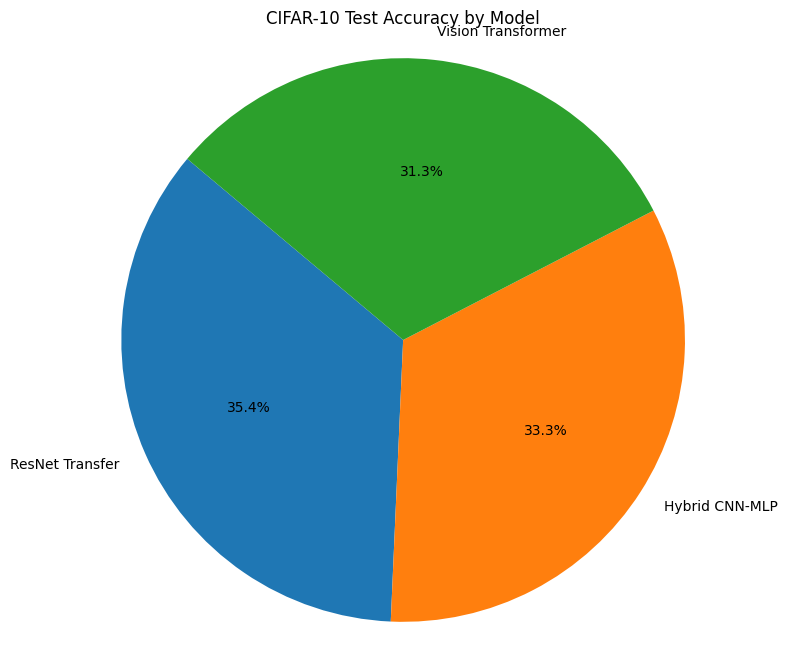

In [13]:
#--------------------------------------------------------------------------
# 6. Main Execution
#--------------------------------------------------------------------------

def main():
    """
    Main function to run the entire training and evaluation pipeline
    """
    print("Starting CIFAR-10 classification with multiple architectures...")

    # Get data loaders
    train_loader, val_loader, test_loader = get_data_loaders()

    # Visualize sample images
    print("Visualizing sample images from dataset...")
    example_data = visualize_samples(train_loader)

    # Initialize all models
    print("Initializing models...")

    # 1. Vision Transformer
    vit_model = VisionTransformer(
        img_size=IMG_SIZE,
        patch_size=PATCH_SIZE,
        in_channels=3,
        num_classes=NUM_CLASSES,
        embed_dim=EMBED_DIM,
        depth=NUM_LAYERS,
        num_heads=NUM_HEADS,
        mlp_ratio=MLP_RATIO,
        drop_rate=DROPOUT
    ).to(device)

    # 2. Hybrid CNN-MLP Model
    hybrid_model = HybridModel(num_classes=NUM_CLASSES).to(device)

    # 3. ResNet Transfer Learning Model
    resnet_model = ResNetTransfer(num_classes=NUM_CLASSES).to(device)

    # Print model summaries
    if device == torch.device('cuda'):
        print("Vision Transformer Architecture:")
        torchsummary.summary(vit_model, (3, IMG_SIZE, IMG_SIZE))
        print("\nHybrid CNN-MLP Architecture:")
        torchsummary.summary(hybrid_model, (3, IMG_SIZE, IMG_SIZE))
        print("\nResNet Transfer Learning Architecture:")
        torchsummary.summary(resnet_model, (3, IMG_SIZE, IMG_SIZE))

    # Dictionary to store all metrics
    all_metrics = {}

    # Train and evaluate Vision Transformer
    print("\n" + "="*50)
    print("Training Vision Transformer (ViT)...")
    vit_optimizer = optim.AdamW(vit_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    vit_scheduler = CosineAnnealingLR(vit_optimizer, T_max=NUM_EPOCHS)
    vit_history = train_model(vit_model, train_loader, val_loader, vit_optimizer, vit_scheduler, NUM_EPOCHS, 'vit')

    # Load best model for evaluation
    vit_model.load_state_dict(torch.load('results/vit_best.pth'))
    vit_metrics, vit_preds, vit_labels = evaluate_model(vit_model, test_loader, 'vit')
    visualize_predictions(vit_model, test_loader, 'vit')
    plot_learning_curves(vit_history, 'vit')
    all_metrics['Vision Transformer'] = vit_metrics

    # Train and evaluate Hybrid CNN-MLP
    print("\n" + "="*50)
    print("Training Hybrid CNN-MLP Model...")
    hybrid_optimizer = optim.AdamW(hybrid_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    hybrid_scheduler = CosineAnnealingLR(hybrid_optimizer, T_max=NUM_EPOCHS)
    hybrid_history = train_model(hybrid_model, train_loader, val_loader, hybrid_optimizer, hybrid_scheduler, NUM_EPOCHS, 'hybrid')

    # Load best model for evaluation
    hybrid_model.load_state_dict(torch.load('results/hybrid_best.pth'))
    hybrid_metrics, hybrid_preds, hybrid_labels = evaluate_model(hybrid_model, test_loader, 'hybrid')
    visualize_predictions(hybrid_model, test_loader, 'hybrid')
    plot_learning_curves(hybrid_history, 'hybrid')
    all_metrics['Hybrid CNN-MLP'] = hybrid_metrics

    # Train and evaluate ResNet Transfer Learning
    print("\n" + "="*50)
    print("Training ResNet Transfer Learning Model...")
    # Only train the classifier parameters
    resnet_params = list(resnet_model.resnet.fc.parameters())
    resnet_optimizer = optim.AdamW(resnet_params, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    resnet_scheduler = CosineAnnealingLR(resnet_optimizer, T_max=NUM_EPOCHS)
    resnet_history = train_model(resnet_model, train_loader, val_loader, resnet_optimizer, resnet_scheduler, NUM_EPOCHS, 'resnet')

    # Load best model for evaluation
    resnet_model.load_state_dict(torch.load('results/resnet_best.pth'))
    resnet_metrics, resnet_preds, resnet_labels = evaluate_model(resnet_model, test_loader, 'resnet')
    visualize_predictions(resnet_model, test_loader, 'resnet')
    plot_learning_curves(resnet_history, 'resnet')
    all_metrics['ResNet Transfer'] = resnet_metrics

    # Compare all models
    print("\n" + "="*50)
    print("Comparing model performance...")
    comparison_df = compare_models(all_metrics)
    print(comparison_df)

    print("\nCIFAR-10 classification complete! Results saved in 'results' directory.")

if __name__ == "__main__":
    main()
